<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Load-train-data" data-toc-modified-id="Load-train-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load train data</a></span></li><li><span><a href="#Load-test-data" data-toc-modified-id="Load-test-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load test data</a></span></li><li><span><a href="#Test-statistics" data-toc-modified-id="Test-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test statistics</a></span></li><li><span><a href="#Train-statistics" data-toc-modified-id="Train-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train statistics</a></span></li><li><span><a href="#Distribution-of-outcome-vs-length-of-history" data-toc-modified-id="Distribution-of-outcome-vs-length-of-history-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Distribution of outcome vs length of history</a></span></li><li><span><a href="#Filter-out-short-periods" data-toc-modified-id="Filter-out-short-periods-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter out short periods</a></span></li><li><span><a href="#Save-filtered" data-toc-modified-id="Save-filtered-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save filtered</a></span></li></ul></div>

# Summary

- Data is reported on Fridays, with a single report per Company (if available) per given day
- Data is more or less evenly distributed for test (Jan 2016 ÷ Sep 2019) and train (Aug 2004 ÷ Dec 2015)  
- Reporting periods for a given Company  may span from 7 days (consistent weekly reporting) to any multiple of 7 (gaps from a week to a year+)
- A gap doesn't guarantee there was no reporting in the period (a 9m gap --> report of an insider trading within 6m --> no current or previous report for a shorter period)
- Number of reports per Company id spans from 1 to 195 in test and to 595 in train
- 9695 stocks in train and 4966 in test
- 24% of Companies in test don't have history in train
- 112 Companies in test are single datapoint, with 59 out of them not having history in train
- There are some interesting artefacts in the data like longer reporting periods seem to positively correlate to better outcomes and other, that need to be explained and incorporated into modeling

%%latex
\newpage

# Load train data

1. Load train features and targets
2. Join targets to features for EDA
2. Convert `float64` to `float32` to save memory footprint and increase performance
3. Rename `tradingitemid` to `idx` and `g__12m_binary` to `target`
5. Check we did not loose any data

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
pd.options.display.max_rows=500


train_target = pd.read_pickle("./data/train_outcomes.pkl")
train_target.rename(mapper={"g__12m_binary": "target"}, axis=1, inplace=True)
train_features = pd.read_pickle("./data/train_features.pkl")
train = train_features.join(train_target, on=["date", "tradingitemid"])
floats = train.select_dtypes(include="float64").columns
train[floats] = train[floats].astype("float32")
train.reset_index(inplace=True)
train.rename(mapper={"tradingitemid": "idx"}, axis=1, inplace=True)
assert len(train_features) == len(train)
# train.to_pickle("./train.pkl")

%%latex
\newpage

# Load test data

1. Load test features
2. Convert `float64` to `float32` for performance
3. Reset index
4. Rename `tradingitemid` to `idx` for convinience

In [2]:
submit = pd.read_pickle("./data/test_features.pkl")
submit[floats] = submit[floats].astype("float32")
submit.reset_index(inplace=True)
submit.rename(mapper={"tradingitemid": "idx"}, axis=1, inplace=True)

# Test statistics

In [3]:
submit.sort_values(["idx", "date",])[
    ["idx", "date","f__buytransactions_1m",
    "f__buytransactions_3m",
    "f__buytransactions_6m",
    "f__buytransactions_12m"]
].head()

,idx,date,f__buytransactions_1m,f__buytransactions_3m,f__buytransactions_6m,f__buytransactions_12m
0,2585893,2016-01-01,1.0,1.0,1.0,13.0
3290,2585893,2016-01-08,11.0,11.0,11.0,15.0
6543,2585893,2016-01-15,10.0,11.0,11.0,15.0
9752,2585893,2016-01-22,10.0,11.0,11.0,15.0
12943,2585893,2016-01-29,12.0,13.0,13.0,17.0


In [4]:
submit.columns

Index(['date', 'idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m'],
      dtype='object')

Test time span:

In [5]:
submit["date"].min(), submit["date"].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2019-09-20 00:00:00'))

Number of unique stocks in test dataset:

In [6]:
submit["idx"].nunique()

4966

The data appears to be more or less evenly distributed along years with some peculiar monthly patterns for start of quarters:

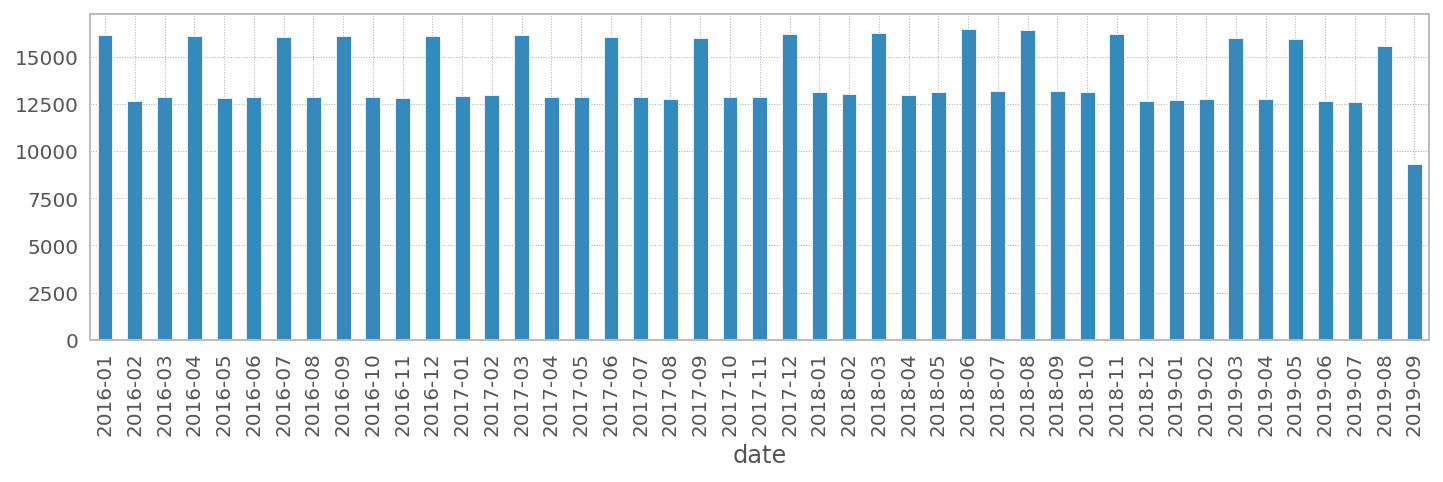

In [7]:
x = submit["date"].dt.strftime("%Y-%m")
x.groupby(x).agg(len).plot(kind="bar", figsize=(12, 3));

The reporting periods seem to be multiples of 7, 7 being by far the most common, then other multiples of 7 in the order of decreasing frequncy:

In [8]:
x = submit[["idx", "date"]].groupby("idx")["date"].transform(
    lambda x: x.diff()
).dt.days

c = Counter(x).most_common(10)
c

[(7.0, 615946),
 (14.0, 2824),
 (21.0, 1117),
 (28.0, 686),
 (35.0, 429),
 (42.0, 291),
 (49.0, 223),
 (56.0, 163),
 (63.0, 139),
 (70.0, 139)]

And the reporting seem to happen on Fridays:

In [9]:
submit["date"].dt.day_name().unique()

array(['Friday'], dtype=object)

Distribution of number of datapoints in test sample available per unique stock id:

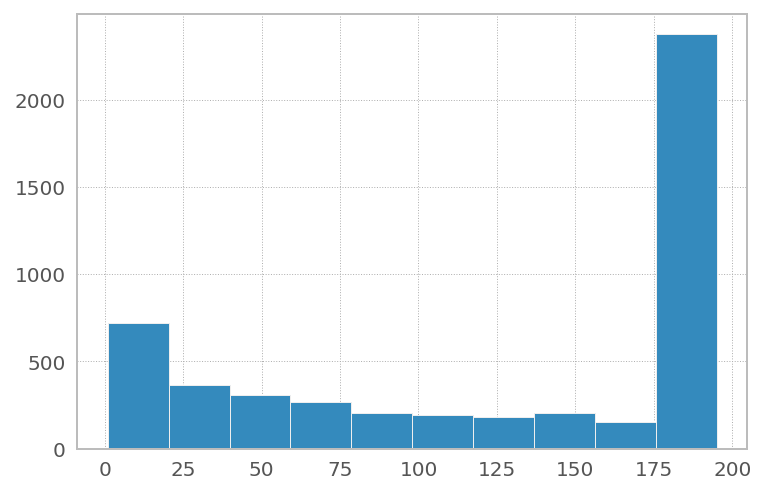

In [10]:
x = submit.groupby("idx")["date"].agg(len)
assert x.sum() == len(submit)
x.hist();

%%latex
\newpage

In [11]:
x.mean()

126.44140153040676

Distribution of reporting periods per Company:

In [12]:
Counter(x).most_common(10)

[(195, 2159),
 (1, 112),
 (2, 75),
 (3, 57),
 (4, 44),
 (5, 44),
 (9, 40),
 (21, 34),
 (8, 34),
 (6, 32)]

Can we enrich data for prediction with history? Let's check number of stocks in test with predecessors in train (overlap with train per stock id):

In [13]:
x = len(set(submit["idx"]) & set(train["idx"]))
x

3791

Share of stocks in test that have predecessors in train:

In [14]:
x / submit["idx"].nunique()

0.7633910592025775

Let's see how length of available data for a stock prediction may change if we add data from train:

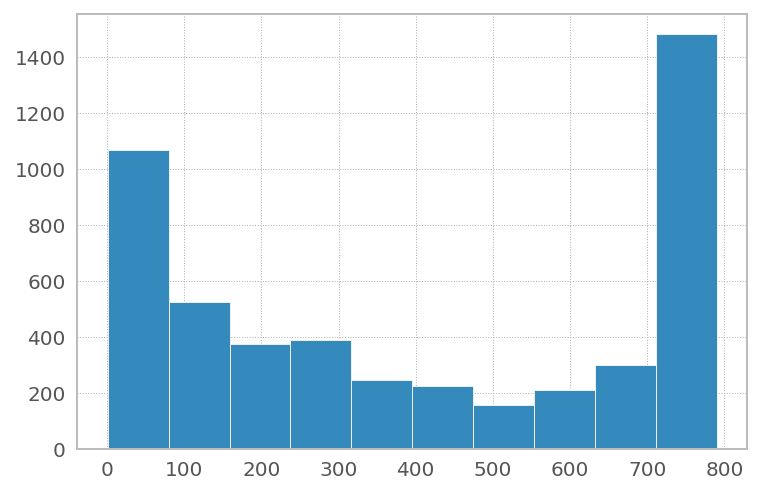

In [15]:
idxs = submit["idx"].unique()
x = (
    submit[["idx", "date"]]
    .append(train[["idx", "date"]][train["idx"].isin(idxs)])
    .groupby("idx")["date"]
    .agg(len)
)
x.hist();

Number of datapoints without history decreased from 112 to 59:

In [16]:
Counter(x.values).most_common(10)

[(790, 1095),
 (1, 59),
 (2, 47),
 (3, 35),
 (4, 27),
 (9, 26),
 (789, 22),
 (5, 21),
 (14, 21),
 (21, 21)]

Length of data available (including the datapoint to be predicted) increased 3x+:

In [17]:
x.mean()

407.29420056383407

In [18]:
# idxs = submit["idx"].unique()
# test = pd.DataFrame()
# for idx in idxs:
#     test = test.append(submit[submit["idx"] == idx]).append(train[train["idx"] == idx])

In [19]:
# (test.groupby("idx")["date"].agg(len) / submit.groupby("idx")["date"].agg(len)).mean()

In [20]:
# test.groupby("idx")["date"].agg(len).hist();

# Train statistics

Total num of datapoints:

In [21]:
len(train)

2106808

In [22]:
train["date"].min(), train["date"].max()

(Timestamp('2004-08-06 00:00:00'), Timestamp('2015-12-25 00:00:00'))

Num of unique stocks:

In [23]:
train["idx"].nunique()

9695

Train data more or less evenly distributed along years with ±20% variance in data volume:

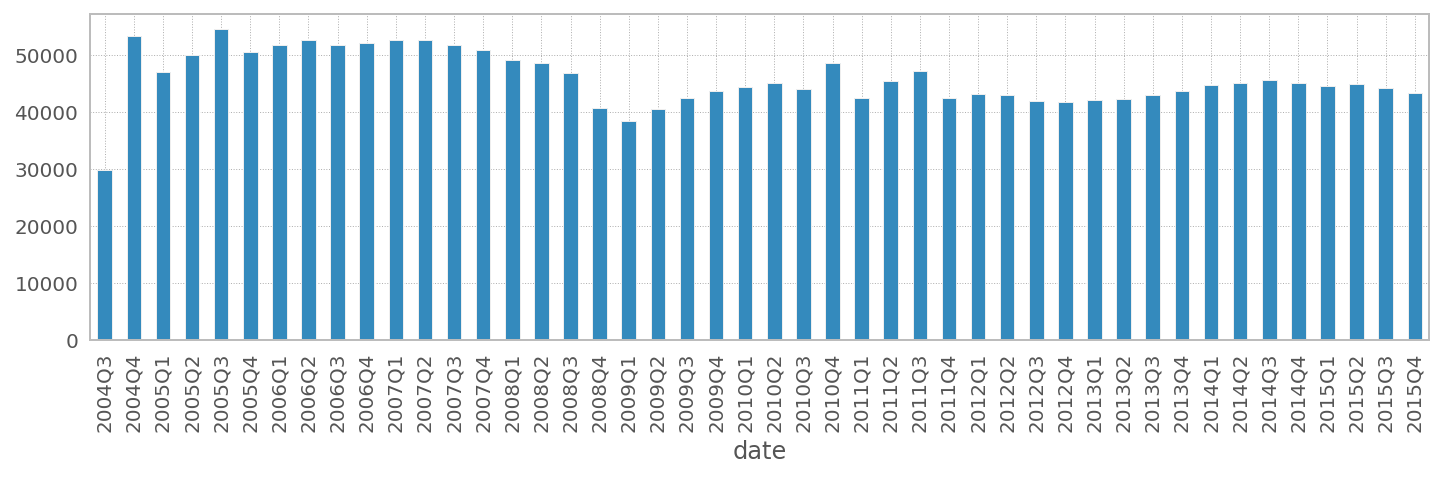

In [24]:
x = train["date"].dt.to_period("Q")
x.groupby(x).agg(len).plot(kind="bar", figsize=(12, 3));

A similar pattern, already observed in test data, is observed in train data with 7 timespan between reports being most common:

In [25]:
x = train[["idx", "date"]].groupby("idx")["date"].transform(
    lambda x: x.diff()
).dt.days

c = Counter(x).most_common(10)
c

[(7.0, 2070367),
 (14.0, 10527),
 (21.0, 4173),
 (28.0, 2374),
 (35.0, 1531),
 (42.0, 1060),
 (49.0, 793),
 (56.0, 627),
 (63.0, 503),
 (70.0, 368)]

Available history datapoints for a particular stock in train:

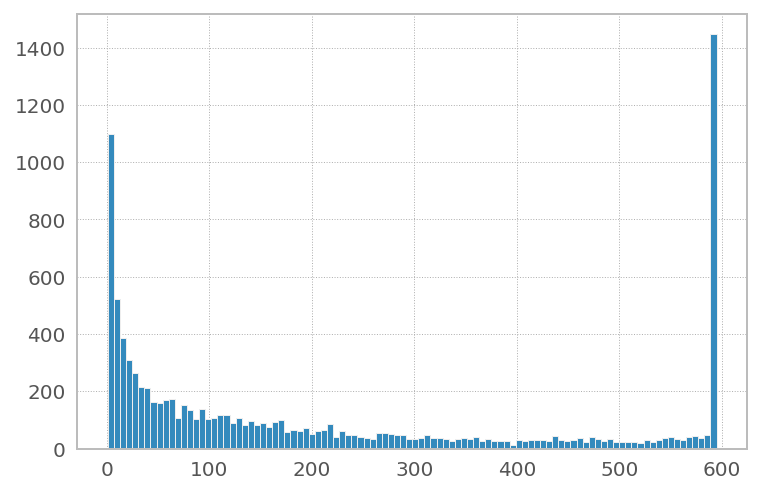

In [26]:
x = train.groupby("idx")["date"].agg(len)
x.hist(bins=100);

%%latex
\newpage

10 most common week lengths of transaction history for a particular stock: 

In [27]:
Counter(x).most_common(10)

[(595, 1364),
 (1, 320),
 (2, 228),
 (3, 184),
 (4, 133),
 (5, 120),
 (8, 119),
 (6, 114),
 (7, 99),
 (15, 85)]

In [28]:
cnt = (
    train.groupby("idx", as_index=False)["date"]
    .agg(len)
    .rename(mapper={"date": "cnt"}, axis=1)
)
train_cnt = train.merge(cnt, how="left")
assert len(train_cnt) == len(train_features)

Targets on a particular day appear balanced:

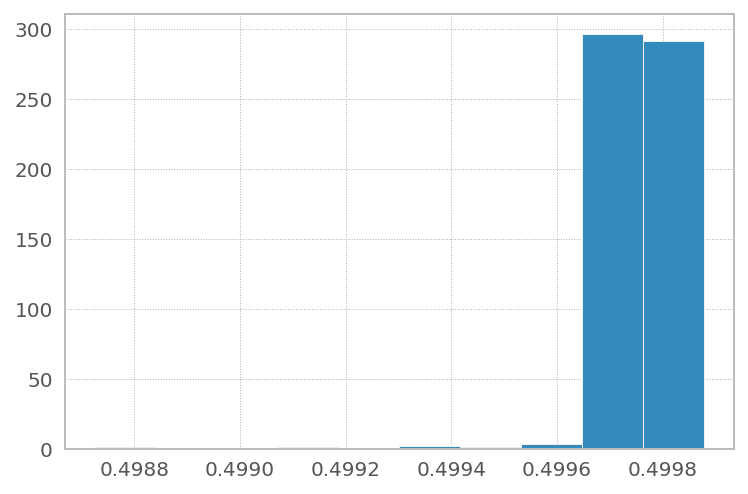

In [29]:
train.groupby("date")["target"].agg("mean").hist();

Number of available stock data on a particular date:

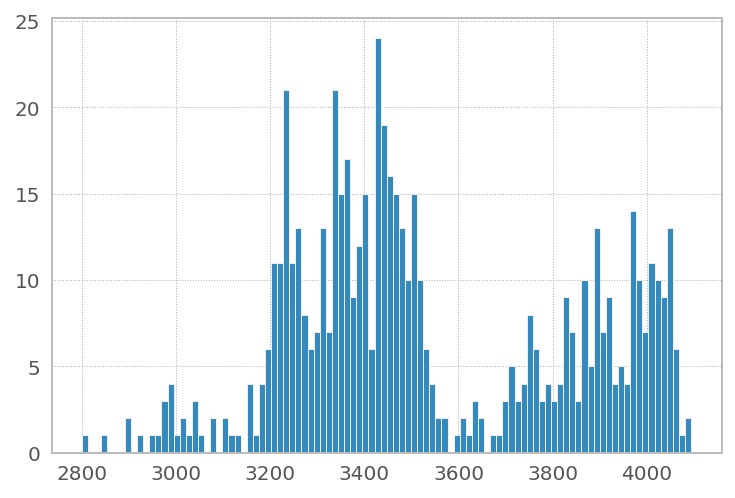

In [30]:
train.groupby("date")["idx"].agg(len).hist(bins=100);

On a single day for a given company we have exactly a single report of summary stats:

In [31]:
x = train.groupby(["date", "idx"])["target"].agg(len)
num, count = np.unique(x, return_counts=True)
assert count == len(train)
num, count

(array([1]), array([2106808]))

# Distribution of outcome vs length of history

In [32]:
train["count"] = train.groupby("idx")["date"].transform("count")
train[train["count"]==1]["target"].mean()

0.1375

In [33]:
train = train.sort_values(["idx","date"],ascending=True)

train["cnt"] = (
    train
    .groupby("idx")["date"]
    .expanding()
    .count()
    .values
)

In [34]:
cnts = train["cnt"].unique()
target = []
for cnt in cnts:
    target.append(train[train["cnt"]==cnt]["target"].mean())

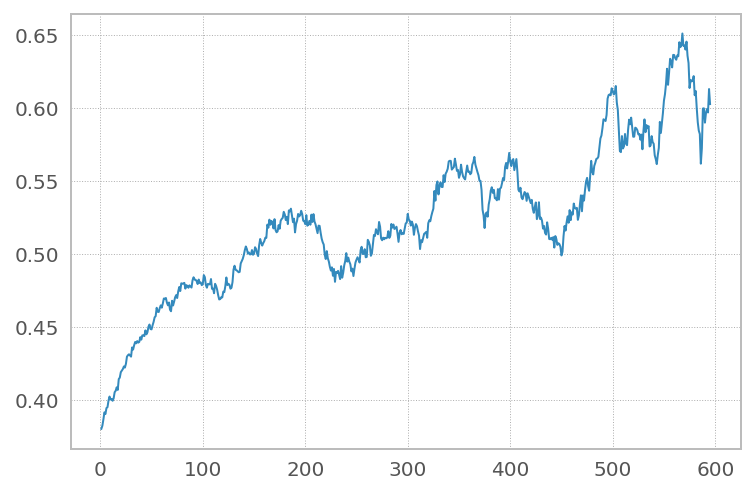

In [35]:
plt.plot(cnts,target);

In [36]:
# 2585893 , 636367352

In [37]:
# train[train["count"]==1].head(2)

In [38]:
# 2586076: all zeros
# 2586166: intermittent non-zeros
# train[train["idx"]==2586166].to_dict(orient="list")

# Filter out short periods

In [39]:
# train[train["cnt"]>=115].sort_values(["idx","date"]).head()

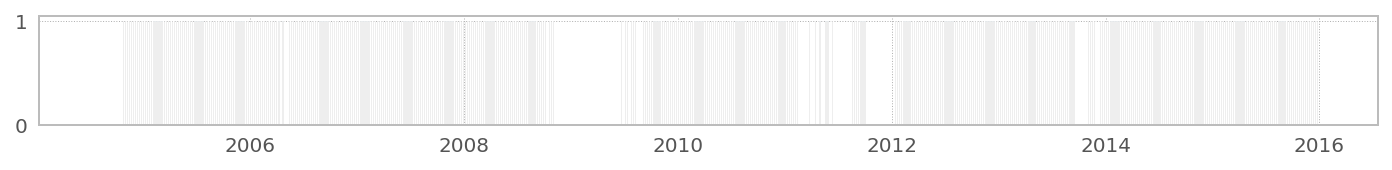

In [40]:
x = train[train["idx"]==2585893]
plt.figure(figsize=(12,1))
plt.bar(x=x["date"], height=x["target"]);

# Save filtered

In [41]:
train.drop("count",axis=1, inplace=True)
train[train["cnt"]>=115].sort_values(["idx","date"]).to_pickle("train_115.pkl")

Most common gaps in days:

In [42]:
Counter(
    train[train["cnt"] >= 115].
    sort_values(["idx", "date"]).
    groupby("idx")["date"].
    diff().dt.days
).most_common(10)

[(7.0, 1351630),
 (14.0, 3335),
 (21.0, 1167),
 (28.0, 640),
 (35.0, 414),
 (42.0, 260),
 (49.0, 212),
 (56.0, 173),
 (63.0, 145),
 (70.0, 94)]

In [43]:
train[train["cnt"] >= 115].groupby("idx",as_index=False)[["idx","date"]].filter(
    lambda x: len(x["date"].diff().dt.days.unique())>2
)["idx"].unique()[:5]

array([2585941, 2585966, 2586260, 2586473, 2586491])

In [44]:
idx = (train[train["idx"]==2585941]["date"].diff().dt.days - 7).astype("bool")
# train[train["idx"]==2585941][idx]

In [45]:
# train[(train["idx"]==2585941) & (train["date"]=="2009-04-17")].to_dict("list")

In [46]:
# train[train["idx"]==2585941].head(300)

In [47]:
len(train)

2106808